In [704]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [705]:
grains = pd.read_csv('datasets/seeds.csv')

In [706]:
grains.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   0               210 non-null    float64
 1   1               210 non-null    float64
 2   2               210 non-null    float64
 3   3               210 non-null    float64
 4   4               210 non-null    float64
 5   5               210 non-null    float64
 6   6               210 non-null    float64
 7   variety_number  210 non-null    int64  
 8   variety         210 non-null    object 
dtypes: float64(7), int64(1), object(1)
memory usage: 14.9+ KB


In [707]:
grains

,0,1,2,3,4,5,6,variety_number,variety
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1,Kama wheat
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1,Kama wheat
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1,Kama wheat
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1,Kama wheat
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1,Kama wheat
...,...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3,Canadian wheat
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3,Canadian wheat
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3,Canadian wheat
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3,Canadian wheat


In [708]:
X = grains.drop(['variety', 'variety_number'], axis=1).values

KMeans Method

Text(0.5, 0, 'K-clusters')

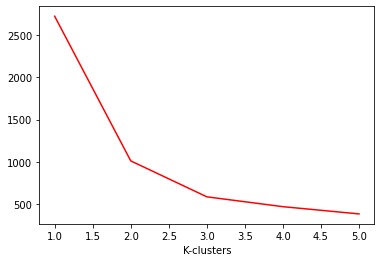

In [709]:
from sklearn.cluster import KMeans

inertias = list()
ks = list(range(1,6))

for k in ks:
    model = KMeans(n_clusters= k)
    model.fit(X)
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-r')
plt.xlabel('K-clusters')



In [710]:
def getDeltas(y_,x_):
    #calculate slopes this might seem confusing but its just a list compression of deltaY/deltaX
    return [(val[0] - y_[i]) / (val[1] - x_[i]) for i, val in enumerate(zip(y_[1:], x_[1:]))]

In [711]:
firstOrd = getDeltas(inertias, ks)
secondOrd = getDeltas(firstOrd,ks)
print(ks)
print(inertias)
print(firstOrd)
print(secondOrd)

[1, 2, 3, 4, 5]
[2719.852410177952, 1011.7123453151189, 587.3186115940426, 471.00339552519216, 385.5072923490437]
[-1708.1400648628332, -424.3937337210763, -116.31521606885048, -85.49610317614844]
[1283.7463311417569, 308.0785176522258, 30.819112892702037]


In [712]:
#K = 3 appears to be the best as the rate of change of the slope starts to approach 0 starting at 3 to 4
model = KMeans(n_clusters=3, random_state= 63)
labels = model.fit_predict(X)
varieties = grains['variety']
df = pd.DataFrame({'labels':labels, 'varieties':varieties})
ct = pd.crosstab(df['labels'], df['varieties'])

In [713]:
#Looks like there are couple errors, lets try preprocessing the data
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(StandardScaler(), model)
labels = pipeline.fit_predict(X)
df = pd.DataFrame({'labels':labels, 'varieties':varieties})
ctscaled = pd.crosstab(df['labels'], df['varieties'])
print(f'Unscaled:\n{ct}\n\nScaled:\n{ctscaled}')



Unscaled:
varieties  Canadian wheat  Kama wheat  Rosa wheat
labels                                           
0                       0           1          60
1                      68           9           0
2                       2          60          10

Scaled:
varieties  Canadian wheat  Kama wheat  Rosa wheat
labels                                           
0                       4          62           5
1                       0           2          65
2                      66           6           0
